<a href="https://colab.research.google.com/github/jcjoshuac/data_science/blob/main/TreeHacks_2023_YouTube_Data_Science_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Let's import all the tools we need for our YouTube data science project.

In [6]:
import math
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F

import numpy as np

import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

from torch.utils.data import Dataset, DataLoader

Let's read our YouTube statistics data (which comes in the form of a csv file) as a pandas dataframe and take a brief look at our data.

In [7]:
youtube_stats_df = pd.read_csv('USvideos.csv') # USvideos.csv dataset taken from Kaggle
youtube_stats_df.head(n=10)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...
5,gHZ1Qz0KiKM,17.14.11,2 Weeks with iPhone X,iJustine,28,2017-11-13T19:07:23.000Z,"ijustine|""week with iPhone X""|""iphone x""|""appl...",119180,9763,511,1434,https://i.ytimg.com/vi/gHZ1Qz0KiKM/default.jpg,False,False,False,Using the iPhone for the past two weeks -- her...
6,39idVpFF7NQ,17.14.11,Roy Moore & Jeff Sessions Cold Open - SNL,Saturday Night Live,24,2017-11-12T05:37:17.000Z,"SNL|""Saturday Night Live""|""SNL Season 43""|""Epi...",2103417,15993,2445,1970,https://i.ytimg.com/vi/39idVpFF7NQ/default.jpg,False,False,False,Embattled Alabama Senate candidate Roy Moore (...
7,nc99ccSXST0,17.14.11,5 Ice Cream Gadgets put to the Test,CrazyRussianHacker,28,2017-11-12T21:50:37.000Z,"5 Ice Cream Gadgets|""Ice Cream""|""Cream Sandwic...",817732,23663,778,3432,https://i.ytimg.com/vi/nc99ccSXST0/default.jpg,False,False,False,Ice Cream Pint Combination Lock - http://amzn....
8,jr9QtXwC9vc,17.14.11,The Greatest Showman | Official Trailer 2 [HD]...,20th Century Fox,1,2017-11-13T14:00:23.000Z,"Trailer|""Hugh Jackman""|""Michelle Williams""|""Za...",826059,3543,119,340,https://i.ytimg.com/vi/jr9QtXwC9vc/default.jpg,False,False,False,"Inspired by the imagination of P.T. Barnum, Th..."
9,TUmyygCMMGA,17.14.11,Why the rise of the robots won’t mean the end ...,Vox,25,2017-11-13T13:45:16.000Z,"vox.com|""vox""|""explain""|""shift change""|""future...",256426,12654,1363,2368,https://i.ytimg.com/vi/TUmyygCMMGA/default.jpg,False,False,False,"For now, at least, we have better things to wo..."


Let's import our machine learning tools (sklearn).

In [8]:
from sklearn import linear_model as lm

linear_model_m1 = lm.LinearRegression(fit_intercept=True)
linear_model_m2 = lm.LinearRegression(fit_intercept=True)

In [9]:
def train_test_split(data):
    """Split the data into training and test data"""
    
    data_len = data.shape[0]
    shuffled_indices = np.random.permutation(data_len)
    train_indices = shuffled_indices[:int(0.8 * data_len)]
    test_indices = shuffled_indices[int(0.8 * data_len):]
    return data.iloc[train_indices], data.iloc[test_indices]
    
train, test = train_test_split(youtube_stats_df)

In [10]:
# Separate our X feature matrix and our y prediction column
youtube_stats_df_train_x = train[['views', 'dislikes', 'comment_count']] # train.drop(columns=["likes"])
youtube_stats_df_train_y = train["likes"]
youtube_stats_df_test_x = test[['views', 'dislikes', 'comment_count']]
youtube_stats_df_test_y = test["likes"]
youtube_stats_df_train_x

,views,dislikes,comment_count
21061,592462,622,4004
36772,703875,317,2998
38519,4523321,1966,5630
28199,1136757,1570,9447
4749,41714,40,450
...,...,...,...
475,4576001,6952,9440
37001,288651,381,433
15326,467560,156,1776
19518,147146,68,1320


In [11]:
# Fit the model
linear_model_m1.fit(youtube_stats_df_train_x, youtube_stats_df_train_y)

# Compute the fitted and predicted values
y_fitted_m1 = linear_model_m1.predict(youtube_stats_df_train_x)
y_predicted_m1 = linear_model_m1.predict(youtube_stats_df_test_x)

In [12]:
predicted_and_actual = {"predicted": y_predicted_m1, "actual": youtube_stats_df_test_y}
predicted_and_actual_df = pd.DataFrame(predicted_and_actual)
predicted_and_actual_df

,predicted,actual
24217,28957.443041,26263
9483,35889.344065,8719
33768,323096.670496,431016
7615,217071.780087,325582
4686,12394.792291,5096
...,...,...
23886,75152.577449,4684
22469,18535.188262,22278
29283,43853.426723,22401
22865,23868.469018,5036


Regression coefficient: 0.9292026668413874
Percentage accuracy:  92.92026668413874%


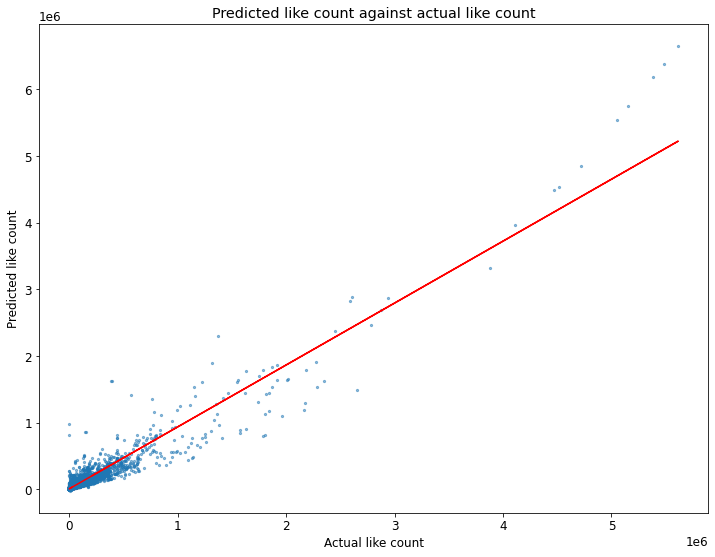

In [13]:
# Plot our predicted and actual like counts with a line of best fit
plt.scatter(x=youtube_stats_df_test_y, y=y_predicted_m1, alpha=0.5, s=5)
plt.title("Predicted like count against actual like count")
plt.xlabel("Actual like count")
plt.ylabel("Predicted like count");

theta = np.polyfit(youtube_stats_df_test_y, y_predicted_m1, 1)
y_line = theta[1] + theta[0] * youtube_stats_df_test_y
plt.plot(youtube_stats_df_test_y, y_line, 'r')

print(f'Regression coefficient: {theta[0]}')
print("Percentage accuracy: ", str(theta[0] * 100) +"%")

Let's test our model on my (@jcjoshuac) Week in the Life of a UC Berkeley student YouTube video.

In [14]:
week_in_the_life_features_df = (pd.DataFrame({"views": [8826], "dislikes": [5], "comment_count": [20]}))#.reset_index()
week_in_the_life_y_predicted = linear_model_m1.predict(week_in_the_life_features_df)
print("Predicted number of likes: " + str(week_in_the_life_y_predicted[0]))

Predicted number of likes: 6856.257862776024


Even though the model is highly accurate, the model performs poorly on this single data point.

Let's take a look at another YouTube statistics dataset.

In [15]:
most_subscribed_channels = pd.read_csv('most_subscribed_youtube_channels.csv') # most_subscribed_youtube_channels.csv dataset taken from Kaggle
most_subscribed_channels.head(n=10)

,rank,Youtuber,subscribers,video views,video count,category,started
0,1,T-Series,"222,000,000","198,459,090,822","17,317",Music,2006
1,2,YouTube Movies,"154,000,000",0,0,Film & Animation,2015
2,3,Cocomelon - Nursery Rhymes,"140,000,000","135,481,339,848",786,Education,2006
3,4,SET India,"139,000,000","125,764,252,686","91,271",Shows,2006
4,5,Music,"116,000,000",0,0,NaN,2013
5,6,PewDiePie,"111,000,000","28,469,458,228","4,497",Gaming,2010
6,7,MrBeast,"102,000,000","16,832,456,681",726,Entertainment,2012
7,8,✿ Kids Diana Show,"99,700,000","79,602,288,245","1,009",People & Blogs,2015
8,9,Like Nastya,"99,200,000","81,963,845,811",702,People & Blogs,2016
9,10,Gaming,"92,700,000",0,0,NaN,2013
